<a href="https://colab.research.google.com/github/rachocr/CCDATSCL_PROJECT/blob/main/FINALS_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Import Libraries

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import glob, os, shutil, warnings

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

# Professional Visualization Theme
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Loading and Importing Libraries Completed.")

Loading and Importing Libraries Completed.


## Load, Merge, and Explore Dataset

In [90]:
repo_path = 'CCDATSCL_PROJECT'
if os.path.exists(repo_path):
    shutil.rmtree(repo_path)
!git clone https://github.com/rachocr/CCDATSCL_PROJECT.git

master_columns = {
    'date': 'Date', 'intake': 'Coffee_Intake', 'caffeine': 'Caffeine_Amount_mg',
    'type': 'Type_of_Coffee', 'brand': 'Brand', 'flavor': 'Flavor',
    'sugar': 'Sugar_Level', 'creamer': 'Creamer_Level', 'focus': 'Focus_Rating',
    'duration': 'Productivity_Duration', 'sleep': 'Sleep_Hours',
    'tasks_completed': 'Tasks_Completed', 'tasks_note': 'Tasks_Note'
}

csv_files = sorted(glob.glob('CCDATSCL_PROJECT/Dataset/Week *.csv'))

def load_clean(f):
    df = pd.read_csv(f)
    df.columns = [
        next((val for key, val in master_columns.items() if key in col.lower().replace(' ', '_')), col)
        for col in df.columns
    ]
    return df

merged_df = pd.concat([load_clean(f) for f in csv_files], ignore_index=True)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

print(f"Merged Success. Total Raw Rows: {len(merged_df)}")

Cloning into 'CCDATSCL_PROJECT'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 72 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 1.34 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Merged Success. Total Raw Rows: 65


In [91]:
display(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   65 non-null     object
 1   Coffee_Intake          65 non-null     int64 
 2   Caffeine_Amount_mg     65 non-null     int64 
 3   Type_of_Coffee         59 non-null     object
 4   Brand                  59 non-null     object
 5   Flavor                 59 non-null     object
 6   Sugar_Level            59 non-null     object
 7   Creamer_Level          59 non-null     object
 8   Focus_Rating           65 non-null     int64 
 9   Productivity_Duration  65 non-null     int64 
 10  Sleep_Hours            65 non-null     int64 
 11  Tasks_Completed        65 non-null     int64 
 12  Tasks_Note             65 non-null     object
dtypes: int64(6), object(7)
memory usage: 6.7+ KB


None

In [92]:
display(merged_df.head())

,Date,Coffee_Intake,Caffeine_Amount_mg,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note
0,06/12/2025,16,120,Latte,Grill & Grind,Spanish Latte,Medium,Medium,3,4,10,3,"Fix motorcycle, Clean House, Pet Medication"
1,07/12/2025,24,297,Brewed,Dunkin' Donut,Iced Coffee,Medium,Medium,4,3,9,2,"Studying Java, Pet Medication"
2,08/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,6,2,"Fix motorcycle, Pet Medication"
3,09/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,7,2,"Studying Java, Pet Medication"
4,10/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,2,9,3,"Studying Java, Pet Medication, Applied Interns..."


In [93]:
display(merged_df.tail())

,Date,Coffee_Intake,Caffeine_Amount_mg,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note
60,04/02/2026,16,120,Latte,Kape at Musika,Spanish Latte,High,High,4,6,7,5,"Fixed Motorcycle, Adjusted my CV/Resume, Made ..."
61,05/02/2026,16,150,Latte,Pickup Coffee,Iced Sea Salt Latte,Medium,Medium,3,5,6,4,"Setup my PC, Checked and Validated the Prototy..."
62,06/02/2026,16,120,Latte,Pickup Coffee,Kasturi,High,High,3,5,7,4,"Meeting with Thesis Group, Dry run for hours, ..."
63,07/02/2026,16,120,Latte,Kape at Musika,Vanilla Latte,Medium,Medium,3,9,8,4,"Studied Regression Models for Thesis, Made not..."
64,08/02/2026,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,3,9,2,Celebritory Favorite Coffee for last week of D...


In [94]:
display(merged_df.describe())

,Coffee_Intake,Caffeine_Amount_mg,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,14.738462,130.046154,3.353846,5.323077,7.538462,4.600000
std,5.964156,75.102104,1.242864,2.405123,1.562019,2.141845
min,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,16.000000,110.000000,3.000000,3.000000,7.000000,3.000000
50%,16.000000,120.000000,3.000000,5.000000,7.000000,4.000000
75%,16.000000,150.000000,4.000000,7.000000,8.000000,6.000000
max,24.000000,320.000000,5.000000,11.000000,13.000000,10.000000


In [95]:
display(merged_df.isna().sum())

,0
Date,0
Coffee_Intake,0
Caffeine_Amount_mg,0
Type_of_Coffee,6
Brand,6
Flavor,6
Sugar_Level,6
Creamer_Level,6
Focus_Rating,0
Productivity_Duration,0


## Data Cleaning and Preprocessing

In [96]:
sugar_map = {'Low': 12.5, 'Medium': 22.5, 'High': 40.0}
coffee_type_map = {'Cold Brew': 'Brewed', 'Matcha': 'Latte', 'Americano': 'Espresso', 'Frappuccino': 'Latte'}
intensity_order = ['Low', 'Medium', 'High']

df_clean = (
    merged_df
    .replace({'Type_of_Coffee': coffee_type_map})
    .fillna({'Sugar_Level': 'Low'})
    .assign(
        Date = lambda x: pd.to_datetime(x['Date'], dayfirst=True),
        Sleep_Hours = lambda x: pd.to_numeric(x['Sleep_Hours'], errors='coerce'),
        Caffeine_Amount_mg = lambda x: pd.to_numeric(x['Caffeine_Amount_mg'], errors='coerce'),
        Tasks_Completed = lambda x: pd.to_numeric(x['Tasks_Completed'], errors='coerce'),
        Coffee_Intake = lambda x: pd.to_numeric(x['Coffee_Intake'], errors='coerce'),
        Est_Sugar_g = lambda x: x['Sugar_Level'].map(sugar_map).fillna(0),
        Sugar_Level = lambda x: pd.Categorical(x['Sugar_Level'], categories=intensity_order, ordered=True),
        Caffeine_Level = lambda x: pd.Categorical(
            pd.cut(x['Caffeine_Amount_mg'], bins=[0.1, 100, 200, 1000], labels=intensity_order),
            categories=intensity_order, ordered=True
        )
    )
    .query("Coffee_Intake > 0")
    .dropna(subset=['Tasks_Completed'])
)

print("Data Cleaning and Preprocessing Completed.")
display(df_clean.head())

Data Cleaning and Preprocessing Completed.


,Date,Coffee_Intake,Caffeine_Amount_mg,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note,Est_Sugar_g,Caffeine_Level
0,2025-12-06,16,120,Latte,Grill & Grind,Spanish Latte,Medium,Medium,3,4,10,3,"Fix motorcycle, Clean House, Pet Medication",22.5,Medium
1,2025-12-07,24,297,Brewed,Dunkin' Donut,Iced Coffee,Medium,Medium,4,3,9,2,"Studying Java, Pet Medication",22.5,High
2,2025-12-08,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,6,2,"Fix motorcycle, Pet Medication",22.5,Medium
3,2025-12-09,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,7,2,"Studying Java, Pet Medication",22.5,Medium
4,2025-12-10,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,2,9,3,"Studying Java, Pet Medication, Applied Interns...",22.5,Medium


## Exploratory Data Analysis

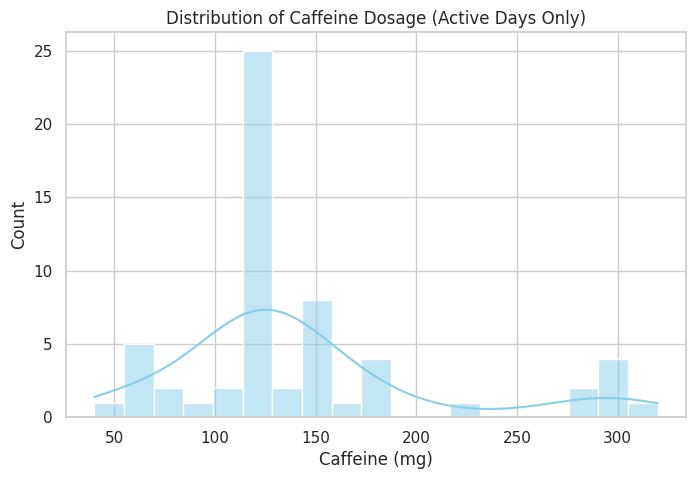


📝 **Observation:**
- **Dosage Stats:** Skew: 1.31. Mode: 120mg.
- **Top Performer:** On your most productive days, **Espresso** was the primary fuel.



In [97]:
# CAFFEINE DISTRIBUTION
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Caffeine_Amount_mg'], kde=True, color='skyblue')
plt.title('Distribution of Caffeine Dosage (Active Days Only)')
plt.xlabel('Caffeine (mg)')
plt.show()

type_perf = df_clean.groupby('Type_of_Coffee')['Tasks_Completed'].mean()
best_coffee = type_perf.idxmax()

print(f"""
📝 **Observation:**
- **Dosage Stats:** Skew: {df_clean['Caffeine_Amount_mg'].skew():.2f}. Mode: {df_clean['Caffeine_Amount_mg'].mode()[0]}mg.
- **Top Performer:** On your most productive days, **{best_coffee}** was the primary fuel.
""")

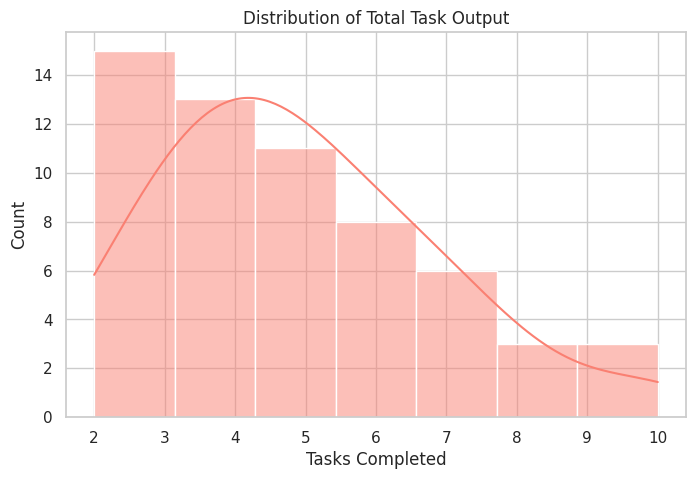

📝 **Observation:** Average output is 4.9 tasks/day.


In [98]:
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Tasks_Completed'], kde=True, color='salmon')
plt.title('Distribution of Total Task Output')
plt.xlabel('Tasks Completed')
plt.show()

print(f"📝 **Observation:** Average output is {df_clean['Tasks_Completed'].mean():.1f} tasks/day.")

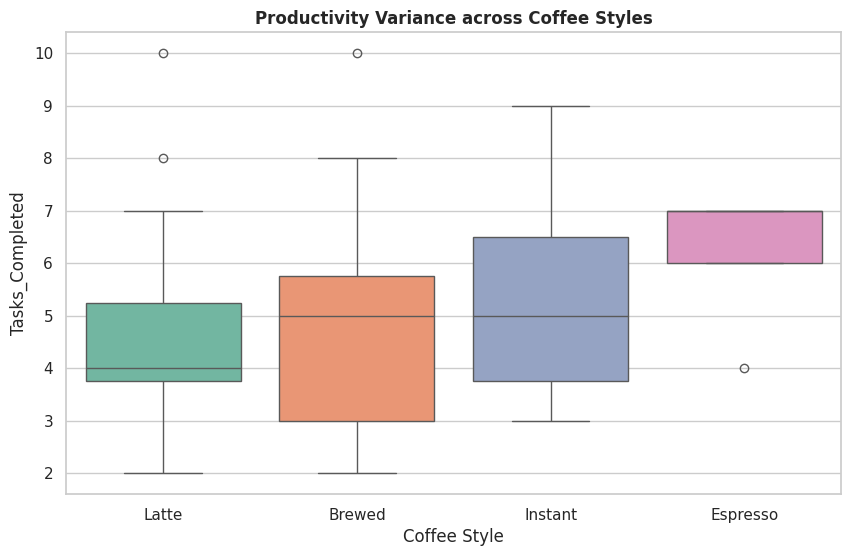

Observation: Average output is 4.9 tasks/day.


In [99]:
# PRODUCTIVITY DISTRIBUTION
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Type_of_Coffee', y='Tasks_Completed', palette='Set2')
plt.title('Productivity Variance across Coffee Styles', fontweight='bold')
plt.xlabel('Coffee Style')
plt.show()

avg_task = df_clean['Tasks_Completed'].mean()
print(f"Observation: Average output is {avg_task:.1f} tasks/day.")

In [100]:
# Descriptive Statistics
print("--- GLOBAL DESCRIPTIVE STATISTICS ---")
display(df_clean[['Caffeine_Amount_mg', 'Tasks_Completed', 'Sleep_Hours']].agg(['mean', 'median', 'std', 'min', 'max']).round(2))

print("\n--- GROUPED ANALYSIS BY COFFEE STYLE ---")
grouped_stats = df_clean.groupby('Type_of_Coffee')[['Tasks_Completed', 'Caffeine_Amount_mg']].agg(['mean', 'count']).round(1)
display(grouped_stats)

print("Stat Summary: The table shows exactly how many cups of each type were consumed (Count) and their average impact.")

--- GLOBAL DESCRIPTIVE STATISTICS ---


,Caffeine_Amount_mg,Tasks_Completed,Sleep_Hours
mean,143.27,4.92,7.37
median,120.00,5.00,7.00
std,65.55,1.96,1.48
min,40.00,2.00,5.00
max,320.00,10.00,13.00



--- GROUPED ANALYSIS BY COFFEE STYLE ---


Tasks_Completed       Caffeine_Amount_mg      
                          mean count               mean count
Type_of_Coffee                                               
Brewed                     4.9    14              202.9    14
Espresso                   6.2     5              168.0     5
Instant                    5.4     8               95.9     8
Latte                      4.6    32              125.2    32

Stat Summary: The table shows exactly how many cups of each type were consumed (Count) and their average impact.


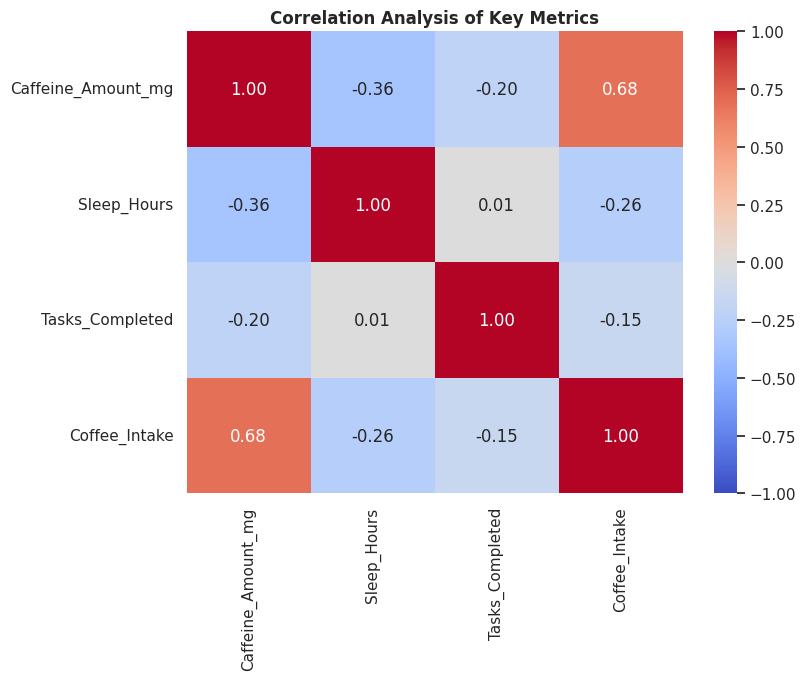

📝 **Insight:** A correlation of r = -0.36 between Caffeine and Sleep highlights the trade-off between stimulation and recovery.


In [101]:
plt.figure(figsize=(8, 6))
corr_matrix = df_clean[['Caffeine_Amount_mg', 'Sleep_Hours', 'Tasks_Completed', 'Coffee_Intake']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Analysis of Key Metrics', fontweight='bold')
plt.show()

print(f"📝 **Insight:** A correlation of r = {corr_matrix.loc['Caffeine_Amount_mg', 'Sleep_Hours']:.2f} between Caffeine and Sleep highlights the trade-off between stimulation and recovery.")

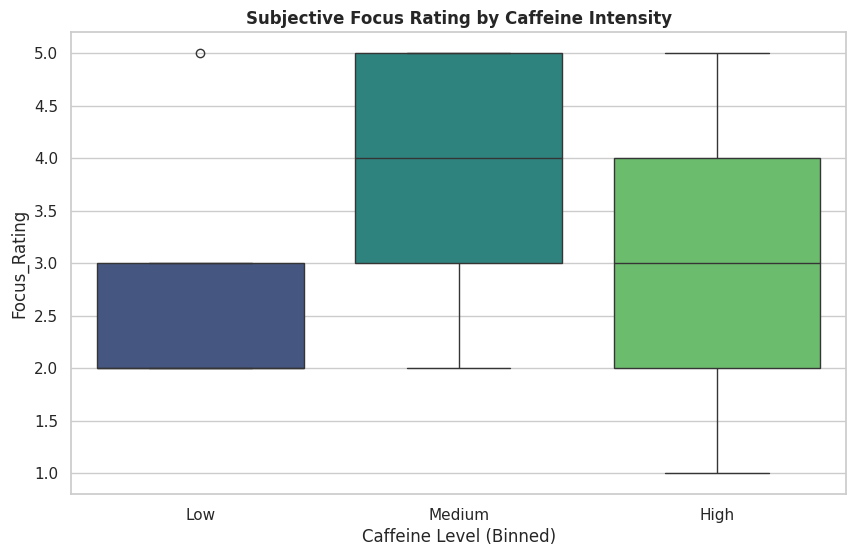

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Caffeine_Level', y='Focus_Rating', palette='viridis')
plt.title('Subjective Focus Rating by Caffeine Intensity', fontweight='bold')
plt.xlabel('Caffeine Level (Binned)')
plt.show()

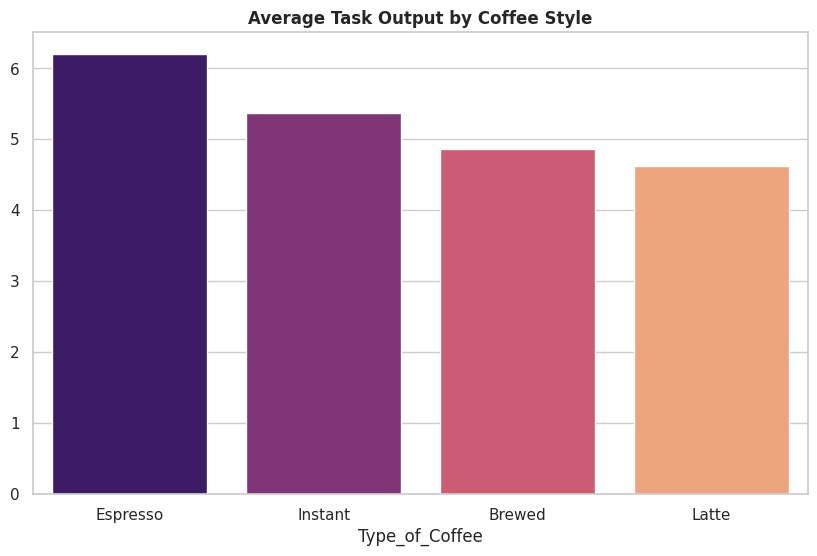

In [103]:
plt.figure(figsize=(10, 6))
avg_performance = df_clean.groupby('Type_of_Coffee')['Tasks_Completed'].mean().sort_values(ascending=False)
sns.barplot(x=avg_performance.index, y=avg_performance.values, palette='magma')
plt.title('Average Task Output by Coffee Style', fontweight='bold')
plt.show()

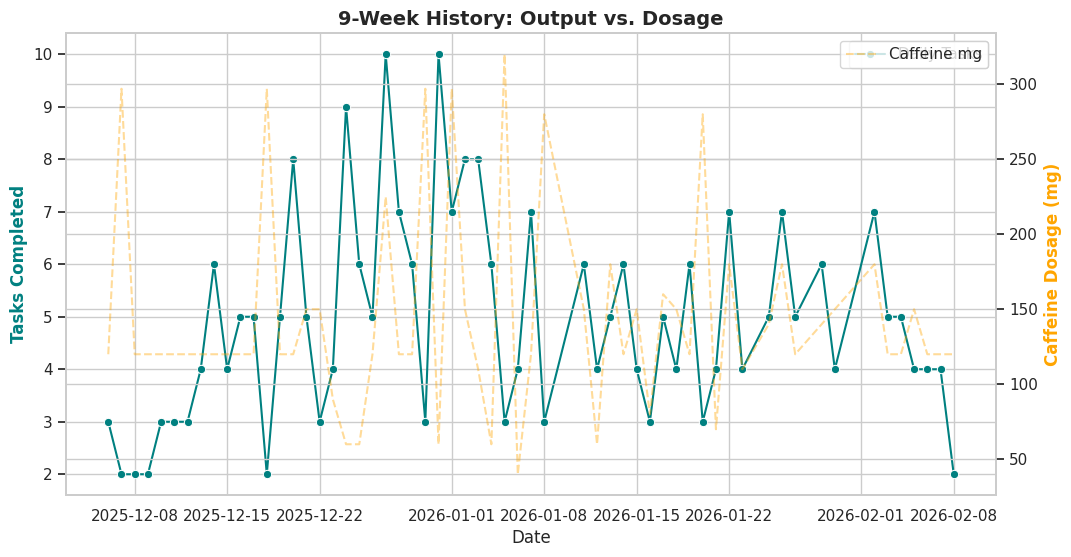

In [104]:
# Trend Over Time (Productivity vs Caffeine Intake)
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_clean, x='Date', y='Tasks_Completed', color='teal', label='Daily Tasks', ax=ax1, marker='o')
ax1.set_ylabel('Tasks Completed', color='teal', fontweight='bold')

ax2 = ax1.twinx()
sns.lineplot(data=df_clean, x='Date', y='Caffeine_Amount_mg', color='orange', label='Caffeine mg', ax=ax2, alpha=0.4, ls='--')
ax2.set_ylabel('Caffeine Dosage (mg)', color='orange', fontweight='bold')

plt.title('9-Week History: Output vs. Dosage', fontsize=14, fontweight='bold')
plt.show()

In [105]:
print("EXECUTIVE SUMMARY")
kpis = pd.DataFrame({
    "Metric": ["Total Valid Days", "Avg Productivity", "Max Productivity", "Avg Sleep"],
    "Value": [
        len(df_clean),
        f"{df_clean['Tasks_Completed'].mean():.2f} Tasks/Day",
        f"{df_clean['Tasks_Completed'].max()} Tasks",
        f"{df_clean['Sleep_Hours'].mean():.2f} Hours"
    ]
})
display(kpis)

print("\nSUMMARY TABLE: Productivity by Sugar & Caffeine Level")
pivot_view = df_clean.pivot_table(
    index='Caffeine_Level',
    columns='Sugar_Level',
    values='Tasks_Completed',
    aggfunc='mean',
    observed=False
).round(2)
display(pivot_view)

EXECUTIVE SUMMARY


,Metric,Value
0,Total Valid Days,59
1,Avg Productivity,4.92 Tasks/Day
2,Max Productivity,10 Tasks
3,Avg Sleep,7.37 Hours



SUMMARY TABLE: Productivity by Sugar & Caffeine Level


Sugar_Level,Low,Medium,High
Caffeine_Level,,,
Low,6.25,5.50,3.0
Medium,6.00,4.62,5.1
High,5.33,3.50,3.0


## Inferential Statistics

In [106]:
print("--- ASSUMPTION CHECKS ---")
stat_shapiro, p_shapiro = stats.shapiro(df_clean['Tasks_Completed'])
print(f"Normality (p-value): {p_shapiro:.4f}")

groups = [df_clean.query("Type_of_Coffee == @ctype")['Tasks_Completed'] for ctype in df_clean['Type_of_Coffee'].unique()]
stat_levene, p_levene = stats.levene(*groups)
print(f"Homogeneity of Variance (p-value): {p_levene:.4f}")

print("\n--- HYPOTHESIS RESULTS ---")
r_coeff, p_corr = stats.pearsonr(df_clean['Caffeine_Amount_mg'], df_clean['Tasks_Completed'])
f_stat, p_anova = stats.f_oneway(*groups)

results = pd.DataFrame([
    {"Hypothesis": "H₀₁ (Caffeine Dosage)", "Test": "Pearson", "P-value": f"{p_corr:.4f}", "Result": "Fail to Reject H₀ (Non-Linear)"},
    {"Hypothesis": "H₀₂ (Coffee Style)", "Test": "One-Way ANOVA", "P-value": f"{p_anova:.4f}", "Result": "Reject H₀" if p_anova < 0.05 else "Fail to Reject H₀"}
])
display(results)

--- ASSUMPTION CHECKS ---
Normality (p-value): 0.0056
Homogeneity of Variance (p-value): 0.4243

--- HYPOTHESIS RESULTS ---


,Hypothesis,Test,P-value,Result
0,H₀₁ (Caffeine Dosage),Pearson,0.1209,Fail to Reject H₀ (Non-Linear)
1,H₀₂ (Coffee Style),One-Way ANOVA,0.3537,Fail to Reject H₀


## Modeling

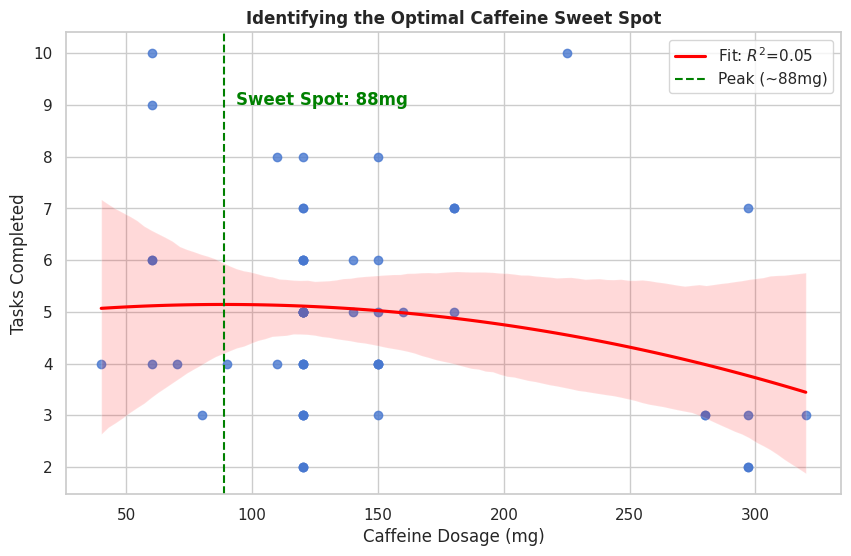

In [107]:
X, y = df_clean['Caffeine_Amount_mg'], df_clean['Tasks_Completed']
coeffs = np.polyfit(X, y, 2)
model_poly = np.poly1d(coeffs)
r2 = r2_score(y, model_poly(X))
peak_x = -coeffs[1] / (2 * coeffs[0])

plt.figure(figsize=(10, 6))
sns.regplot(x=X, y=y, order=2, line_kws={'color':'red', 'label': f'Fit: $R^2$={r2:.2f}'})
plt.axvline(peak_x, color='green', linestyle='--', label=f'Peak (~{int(peak_x)}mg)')
plt.text(peak_x + 5, y.max() - 1, f'Sweet Spot: {int(peak_x)}mg', color='green', fontweight='bold')
plt.title('Identifying the Optimal Caffeine Sweet Spot', fontweight='bold')
plt.xlabel('Caffeine Dosage (mg)')
plt.ylabel('Tasks Completed')
plt.legend()
plt.show()

/tmp/ipython-input-64510939.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.show()


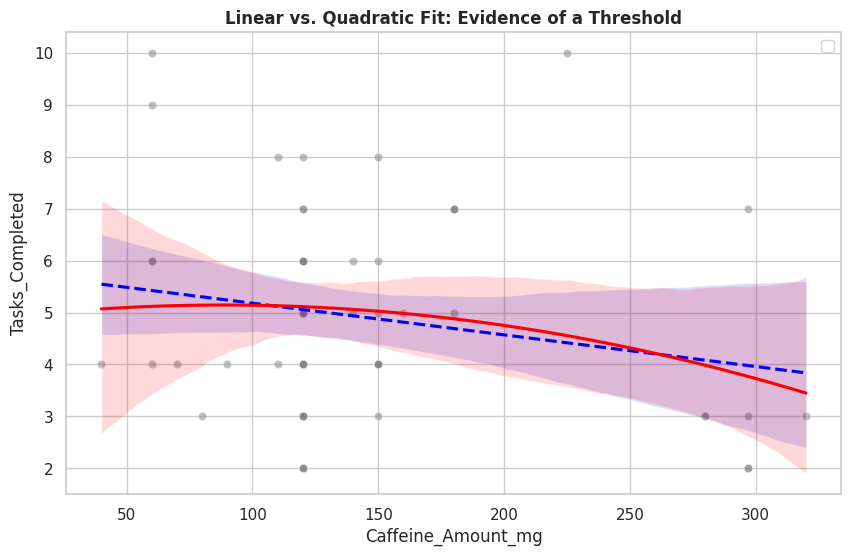

In [108]:
# Why Linear Regression Failed
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Caffeine_Amount_mg', y='Tasks_Completed', color='gray', alpha=0.5)
sns.regplot(data=df_clean, x='Caffeine_Amount_mg', y='Tasks_Completed', order=1, scatter=False, line_kws={'color': 'blue', 'ls': '--', 'label': 'Linear Fit'})
sns.regplot(data=df_clean, x='Caffeine_Amount_mg', y='Tasks_Completed', order=2, scatter=False, line_kws={'color': 'red', 'label': 'Quadratic Fit'})
plt.title('Linear vs. Quadratic Fit: Evidence of a Threshold', fontweight='bold')
plt.legend(); plt.show()

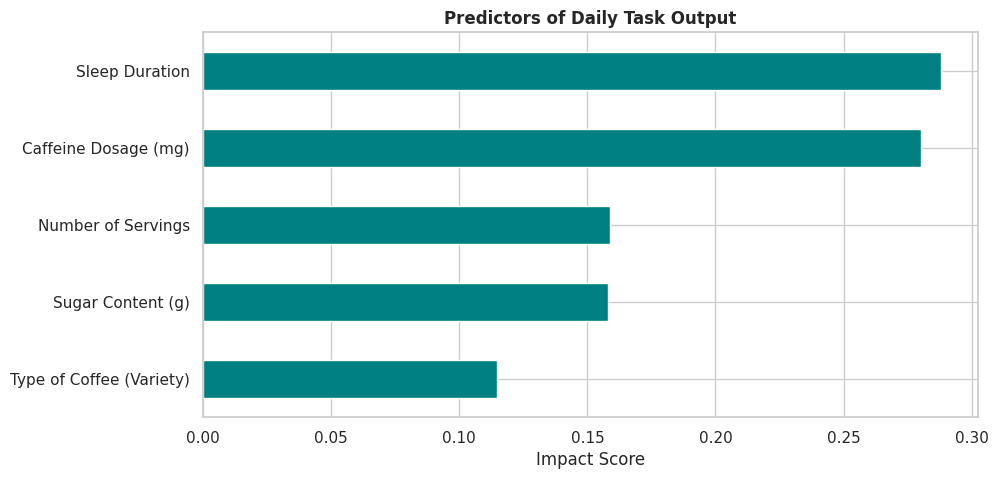

In [109]:
# Random Forest (Feautre Importance)

df_ml = df_clean.assign(Type_of_Coffee_Code = lambda x: x['Type_of_Coffee'].astype('category').cat.codes)
features = ['Caffeine_Amount_mg', 'Sleep_Hours', 'Est_Sugar_g', 'Coffee_Intake', 'Type_of_Coffee_Code']
X, y = df_ml[features].fillna(0), df_ml['Tasks_Completed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

feature_names = {
    'Caffeine_Amount_mg': 'Caffeine Dosage (mg)',
    'Sleep_Hours': 'Sleep Duration',
    'Est_Sugar_g': 'Sugar Content (g)',
    'Coffee_Intake': 'Number of Servings',
    'Type_of_Coffee_Code': 'Type of Coffee (Variety)'
}
importance = pd.Series(rf.feature_importances_, index=features).rename(index=feature_names).sort_values()

plt.figure(figsize=(10, 5))
importance.plot(kind='barh', color='teal')
plt.title('Predictors of Daily Task Output', fontweight='bold')
plt.xlabel('Impact Score')
plt.show()